In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score


In [3]:
data=pd.read_csv("./Synthetic_Financial_datasets_log.csv")
data =data.sample(n=200000,random_state=42)

data.shape
data.head

<bound method NDFrame.head of          step      type      amount     nameOrig  oldbalanceOrg  \
3737323   278   CASH_IN   330218.42   C632336343       20866.00   
264914     15   PAYMENT    11647.08  C1264712553       30370.00   
85647      10   CASH_IN   152264.21  C1746846248      106589.00   
5899326   403  TRANSFER  1551760.63   C333676753           0.00   
2544263   206   CASH_IN    78172.30   C813403091     2921331.58   
...       ...       ...         ...          ...            ...   
670946     36  TRANSFER   717358.21   C158880018       67206.00   
3032934   234  CASH_OUT   160399.88   C802841322       10669.00   
4751985   333  TRANSFER  3270141.36  C1008303693           0.00   
1239897   134   CASH_IN   373726.88  C1002035443     1655191.80   
1027972    48   PAYMENT    12092.77   C815071087      200746.00   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
3737323       351084.42   C834976624       452419.57       122201.15        0   
264

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 3737323 to 1027972
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            200000 non-null  int64  
 1   type            200000 non-null  object 
 2   amount          200000 non-null  float64
 3   nameOrig        200000 non-null  object 
 4   oldbalanceOrg   200000 non-null  float64
 5   newbalanceOrig  200000 non-null  float64
 6   nameDest        200000 non-null  object 
 7   oldbalanceDest  200000 non-null  float64
 8   newbalanceDest  200000 non-null  float64
 9   isFraud         200000 non-null  int64  
 10  isFlaggedFraud  200000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 18.3+ MB


In [7]:
print(data.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [9]:
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
print(data['type'])

3737323    0
264914     3
85647      0
5899326    4
2544263    0
          ..
670946     4
3032934    1
4751985    4
1239897    0
1027972    3
Name: type, Length: 200000, dtype: int64


In [10]:
data = data.drop(columns=['nameOrig', 'nameDest'])

In [11]:
X = data.drop('isFraud', axis=1)
y = data['isFraud']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (160000, 8)
Testing data shape: (40000, 8)


In [15]:
# Create the XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=200,  # Number of trees
    max_depth=6,       # Maximum depth of a tree
    learning_rate=0.1, # Step size shrinkage
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=False)


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [16]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("ROC-AUC Score:", roc_auc)

Accuracy: 0.999725
Confusion Matrix:
 [[39945     1]
 [   10    44]]
ROC-AUC Score: 0.9991882559974484


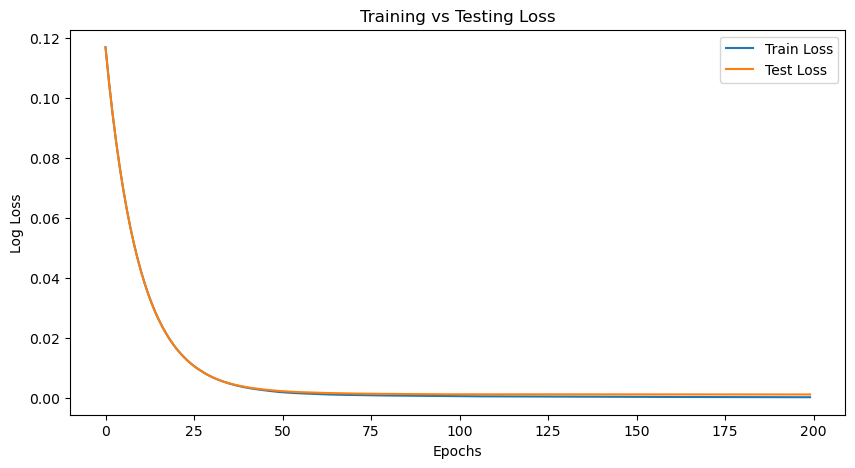

In [17]:
# Extract evaluation results
results = model.evals_result()

# Plot training and testing loss
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Loss')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Testing Loss')
plt.show()